In [ ]:
!pip install scanpy matplotlib numpy pandas pybiomart scikit-misc scvi-tools

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of orbax-checkpoint to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.2/503.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from pybiomart import Server
import scipy.sparse
import warnings
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [ ]:
gene_poisson_genecell_zinb = pd.read_csv("/content/gdrive/MyDrive/2. Data Science Mini Project/dsmp-data-2024-2025/QCed data/Models/Score files/gene__poisson__gene_cell__zinb.csv")
genebatch_nb = pd.read_csv("/content/gdrive/MyDrive/2. Data Science Mini Project/dsmp-data-2024-2025/QCed data/Models/Score files/gene_batch__nb_score.csv")
genebatch_poisson = pd.read_csv("/content/gdrive/MyDrive/2. Data Science Mini Project/dsmp-data-2024-2025/QCed data/Models/Score files/gene_batch__poisson.csv")
genebatch_zinb = pd.read_csv("/content/gdrive/MyDrive/2. Data Science Mini Project/dsmp-data-2024-2025/QCed data/Models/Score files/gene_batch__znb_score.csv")
genecell_nb = pd.read_csv("/content/gdrive/MyDrive/2. Data Science Mini Project/dsmp-data-2024-2025/QCed data/Models/Score files/gene_cell__nb.csv")
genecell_poisson = pd.read_csv("/content/gdrive/MyDrive/2. Data Science Mini Project/dsmp-data-2024-2025/QCed data/Models/Score files/gene_cell__poisson.csv")
gene_nb = pd.read_csv("/content/gdrive/MyDrive/2. Data Science Mini Project/dsmp-data-2024-2025/QCed data/Models/Score files/gene_nb.csv")
gene_zinb = pd.read_csv("/content/gdrive/MyDrive/2. Data Science Mini Project/dsmp-data-2024-2025/QCed data/Models/Score files/gene_zinb.csv")

In [ ]:
gene_poisson = gene_poisson_genecell_zinb.iloc[0:20]
genecell_zinb = gene_poisson_genecell_zinb.iloc[20:40]

# Example: assuming your 8 DataFrames are named df1 to df8
dfs = [genecell_zinb,gene_poisson, genebatch_nb, genebatch_poisson, genebatch_zinb,
       genecell_nb, genecell_poisson, gene_nb, gene_zinb]

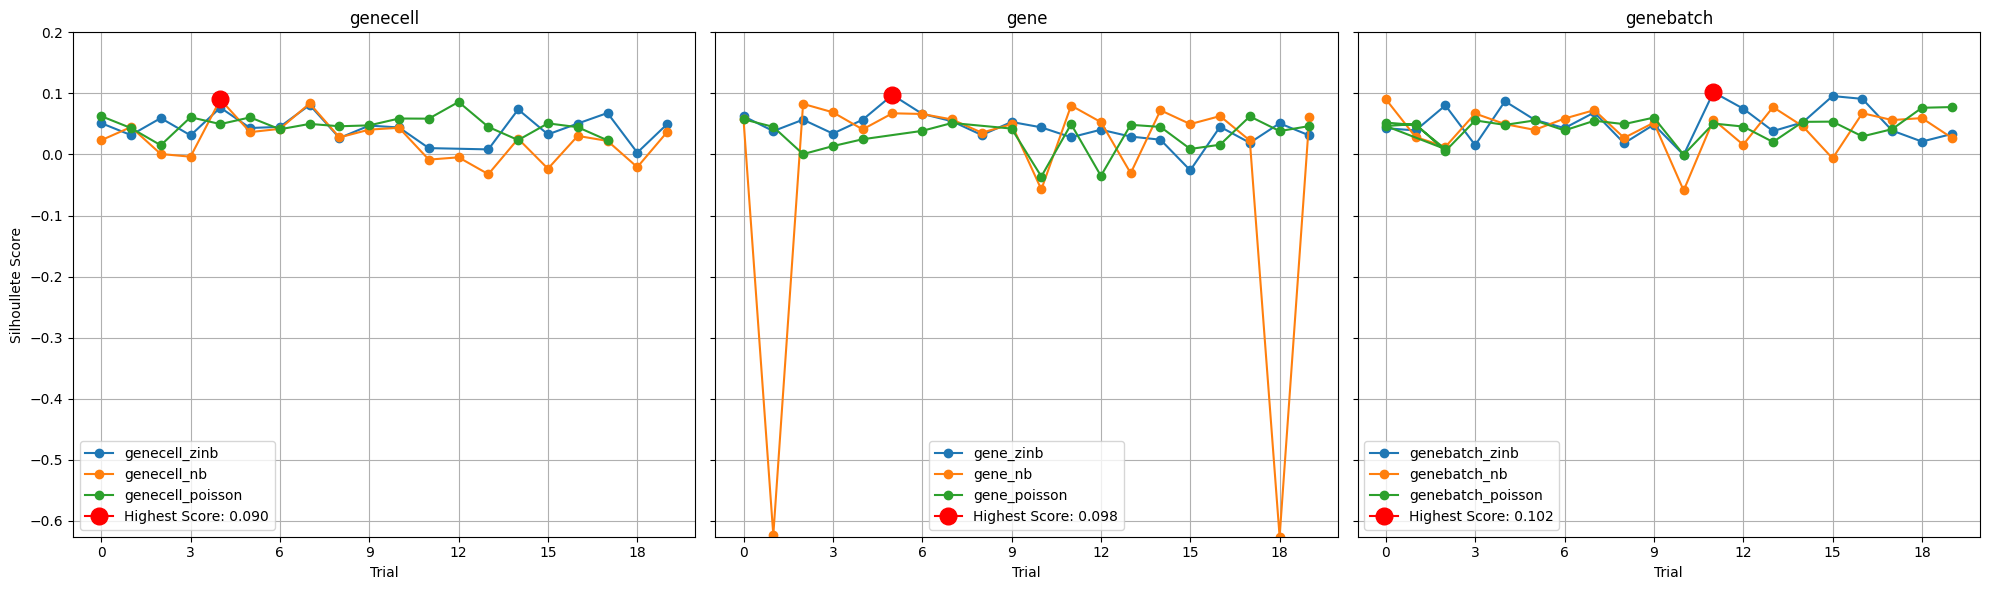

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Define the groups of DataFrames along with their labels
group1 = [
    (genecell_zinb, "genecell_zinb"),
    (genecell_nb, "genecell_nb"),
    (genecell_poisson, "genecell_poisson")
]

group2 = [
    (gene_zinb, "gene_zinb"),
    (gene_nb, "gene_nb"),
    (gene_poisson, "gene_poisson")
]

group3 = [
    (genebatch_zinb, "genebatch_zinb"),
    (genebatch_nb, "genebatch_nb"),
    (genebatch_poisson, "genebatch_poisson")
]

# Combine all groups to compute the global minimum (ignoring the outlier -999)
all_groups = group1 + group2 + group3
global_min = min(df.loc[df["score"] != -999, "score"].min() for df, _ in all_groups)

# Create a figure with three subplots arranged in a row, sharing the y-axis
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
titles = ["genecell", "gene", "genebatch"]

# Loop over each subplot and its corresponding group
for ax, group, title in zip(axes, [group1, group2, group3], titles):
    # Initialize variables to store the highest score and corresponding trial for the group
    group_max_value = -float('inf')
    group_max_trial = None

    # Plot each DataFrame in the group
    for df, label in group:
        # Filter out outlier values (-999)
        valid_df = df[df["score"] != -999]
        ax.plot(valid_df["trial"], valid_df["score"], marker='o', linestyle='-', label=label)

        # Determine the highest score in this line
        if not valid_df.empty:
            local_max = valid_df["score"].max()
            if local_max > group_max_value:
                group_max_value = local_max
                group_max_trial = valid_df.loc[valid_df["score"].idxmax(), "trial"]

    # Highlight the overall highest score in the group with a red star and include its value in the legend
    if group_max_trial is not None:
        highest_label = f"Highest Score: {group_max_value:.3f}"
        ax.plot(group_max_trial, group_max_value, marker='o', markersize=12, color='red', label=highest_label)

    ax.set_title(title)
    ax.set_xlabel("Trial")
    ax.set_ylim(global_min, 0.2)
    ax.grid(True)
    # Set x-axis ticks to display only integers
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend()

# Set a common y-axis label for the leftmost subplot
axes[0].set_ylabel("Silhoullete Score")

plt.tight_layout()
plt.show()


In [ ]:
groups = [
    (group1, "genecell"),
    (group2, "gene"),
    (group3, "genebatch")
]

# For each group, determine the row with the highest score (ignoring outliers: score == -999)
for group, group_name in groups:
    group_max_value = -float('inf')
    best_row = None
    best_df_label = None

    # Iterate over each DataFrame in the group
    for df, label in group:
        # Filter out outlier rows
        valid_df = df[df["score"] != -999]
        if not valid_df.empty:
            local_max = valid_df["score"].max()
            if local_max > group_max_value:
                group_max_value = local_max
                best_row = valid_df.loc[valid_df["score"].idxmax()]
                best_df_label = label

    # Print the column names and values of the row with the highest score in the group
    if best_row is not None:
        print(f"Group '{group_name}' (from DataFrame '{best_df_label}') highest score row:")
        for col, val in best_row.items():
            print(f"  {col}: {val}")
        print()  # Blank line for better readability

Group 'genecell' (from DataFrame 'genecell_nb') highest score row:
  trial: 4
  score: 0.090120956
  n_latent: 40
  n_hidden: 256
  n_layers: 1
  dropout_rate: 0.2
  dispersion: gene-cell
  gene_likelihood: nb
  latent_distribution: ln
  max_epochs: 100
  learning_rate: 0.001874221
  batch_size: 256

Group 'gene' (from DataFrame 'gene_zinb') highest score row:
  trial: 5
  score: 0.0975072681903839
  n_latent: 20
  n_hidden: 128
  n_layers: 1
  dropout_rate: 0.45
  dispersion: gene
  gene_likelihood: zinb
  latent_distribution: ln
  max_epochs: 500
  learning_rate: 0.0004325207525386
  batch_size: 256

Group 'genebatch' (from DataFrame 'genebatch_zinb') highest score row:
  trial: 11
  dispersion: gene_batch
  gene_likelihood: znb
  score: 0.101953819
  n_latent: 50
  n_hidden: 256
  n_layers: 1
  dropout_rate: 0.25
  latent_distribution: ln
  max_epochs: 200
  learning_rate: 0.000557618
  batch_size: 256

